In [1]:
import copy
import sys
sys.path.insert(0, "../../")
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Animator, Atom_Collection_Plotter
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher1
from classes.optimizers.md_simulator1 import MDTP_simulator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rc('animation', html='jshtml')

In [2]:
class Atom_plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
    
    def animate(self, i, atom_col, position, plot_several_cells=False):
        atom_col.set_atom_positions(position)
        plot_elems_atoms = self(atom_col)
        add_plot_elems = []
        if plot_several_cells == False:
            pass
        else:
            add_plot_elems = self.plot_several_cells(atom_col=atom_col)
            add_plot_elems = [f for d in add_plot_elems
                                for l in d
                                for f in l]
        return plot_elems_atoms["atoms"] + add_plot_elems

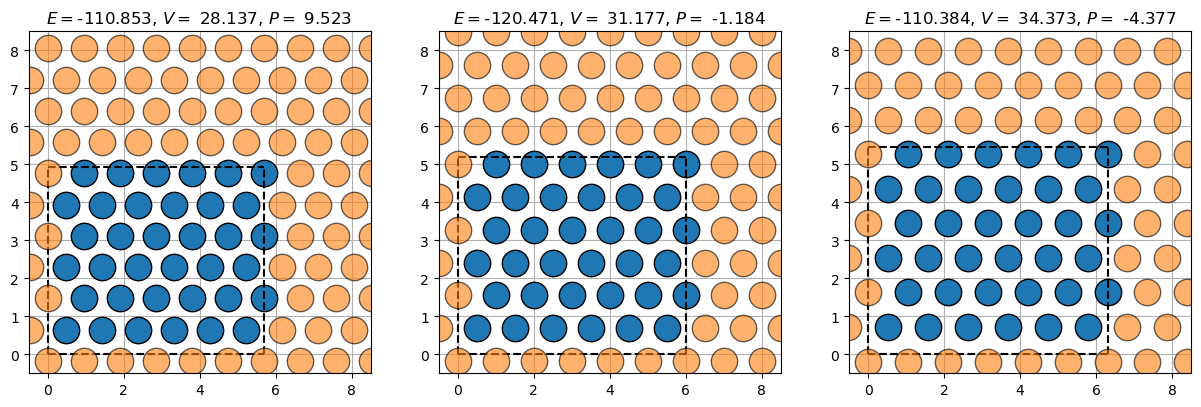

In [3]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
atom_writer = Atom_File_handler()
atom_plotter = Atom_plotter(markersize=19)
opt_col = atom_writer.load_atom_collections(filename="../exercise 36/opt_atom_col")[0]

l1, l2 = opt_col.unit_cell
pos_opt = opt_col.positions
new_poses = []
for i in [0.0, 1.0, 2.0]:
    for j in [0.0, 1.0, 2.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([6.0, 0.0]), 3*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]


scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,8.5])
    ax.set_ylim([-0.5,8.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos) for pos in np.array(new_poses).reshape(6**2, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones(eps0=1.0)
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_plotter(atom_col=atom_col, ax=ax, plot_cell=True)
    atom_plotter.plot_several_cells(atom_col=atom_col, ax=ax)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)


In [4]:
logged_atom_cols = []
for scaled_col in [scaled_cols[0], scaled_cols[-1]]:
    md_simulator = MDTP_simulator(atom_col=scaled_col, temp=0.05)
    md_simulator.run_MDsimulation(gamma=1e-2, N_steps=200, max_scale=1e-3)
    logged_atom_cols.append(md_simulator.logged_atom_cols)

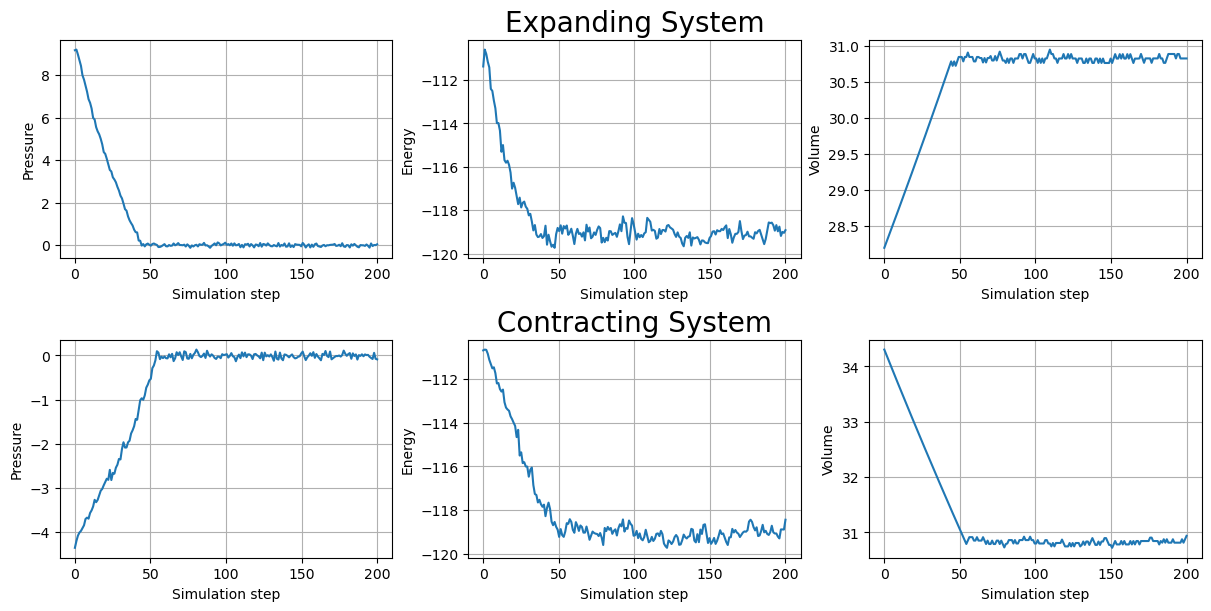

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(12,6), layout="constrained")
titles = ["Expanding System", "Contracting System"]
for ax_row, logged_cols, title in zip(axs, logged_atom_cols, titles):
    ax_row[0].set_ylabel("Pressure")
    ax_row[1].set_ylabel("Energy")
    ax_row[2].set_ylabel("Volume")
    ax_row[1].set_title(title, fontsize=20)

    ps = [logged_col.get_pressure() for logged_col in logged_cols]
    vs = [logged_col.get_volume() for logged_col in logged_cols]
    es = [logged_col.get_potential_energy() for logged_col in logged_cols]
    xs = np.linspace(0,len(ps), len(ps))

    for ax, plot_elem in zip(ax_row, [ps, es, vs]):
        ax.grid()
        ax.plot(xs, plot_elem)
        ax.set_xlabel("Simulation step")
    

In [21]:
temps = [0.40, 0.45, 0.50, 0.55, 0.60, 0.60, 0.55, 0.50, 0.45, 0.40]
atom_col = copy.deepcopy(scaled_cols[1])
md_simulator = MDTP_simulator(atom_col=atom_col,temp=0.15)
total_logged_cols = []
for temp in temps:
    md_simulator.temp = temp
    md_simulator.run_MDsimulation(N_steps=600, gamma=1e-2, max_scale=5e-4)
    total_logged_cols.append(md_simulator.logged_atom_cols)
    md_simulator.logged_atom_cols = []

In [22]:
volumes_mean = []
pressures_mean = []
energies_mean = []
for temp, atom_cols in zip(temps, total_logged_cols):
    volumes = []
    energies = []
    pressures = []
    for atom_coll in atom_cols:
        volumes.append(atom_coll.get_volume())
        pressures.append(atom_coll.get_pressure())
        energies.append(atom_coll.get_potential_energy())
    pressures_mean.append(np.mean(pressures[:-int(300)]))
    volumes_mean.append(np.mean(volumes[:-int(300)]))
    energies_mean.append(np.mean(energies[:-int(300)]))

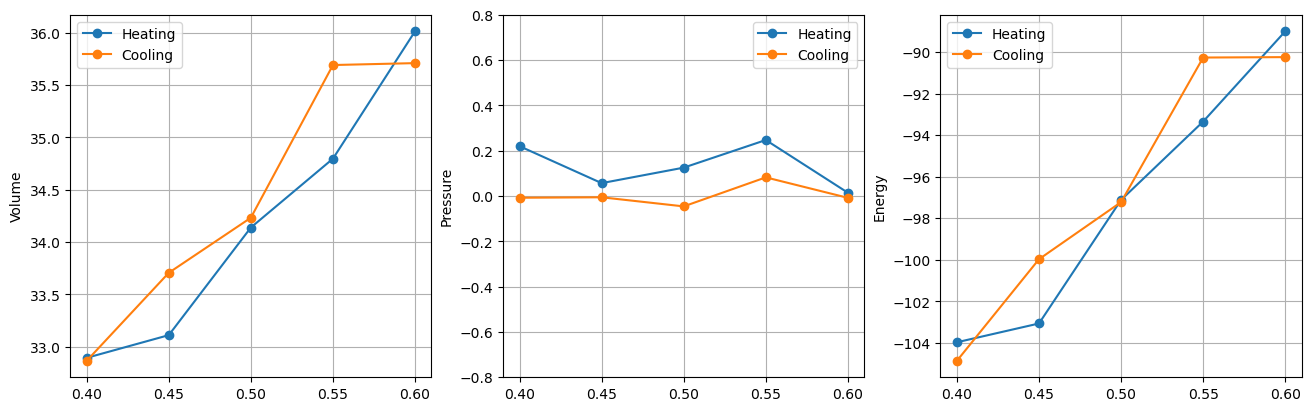

In [27]:
fig, axs = plt.subplots(1,3, figsize=(13,4), layout="constrained")

axs[0].plot(temps[0:5], volumes_mean[0:5],"o-", c="C0", label="Heating")
axs[0].set_ylabel("Volume")
axs[1].plot(temps[0:5], pressures_mean[0:5], "o-", c="C0", label="Heating")
axs[1].set_ylabel("Pressure")
axs[1].set_ylim([-0.8,0.8])
axs[2].plot(temps[0:5], energies_mean[0:5], "o-", c="C0", label="Heating")
axs[2].set_ylabel("Energy")
axs[0].plot(temps[5:], volumes_mean[5:], "o-", c="C1", label="Cooling")
axs[1].plot(temps[5:], pressures_mean[5:], "o-", c="C1", label="Cooling")
axs[2].plot(temps[5:], energies_mean[5:], "o-", c="C1", label="Cooling")
for ax in axs:
    ax.legend()
    ax.grid()

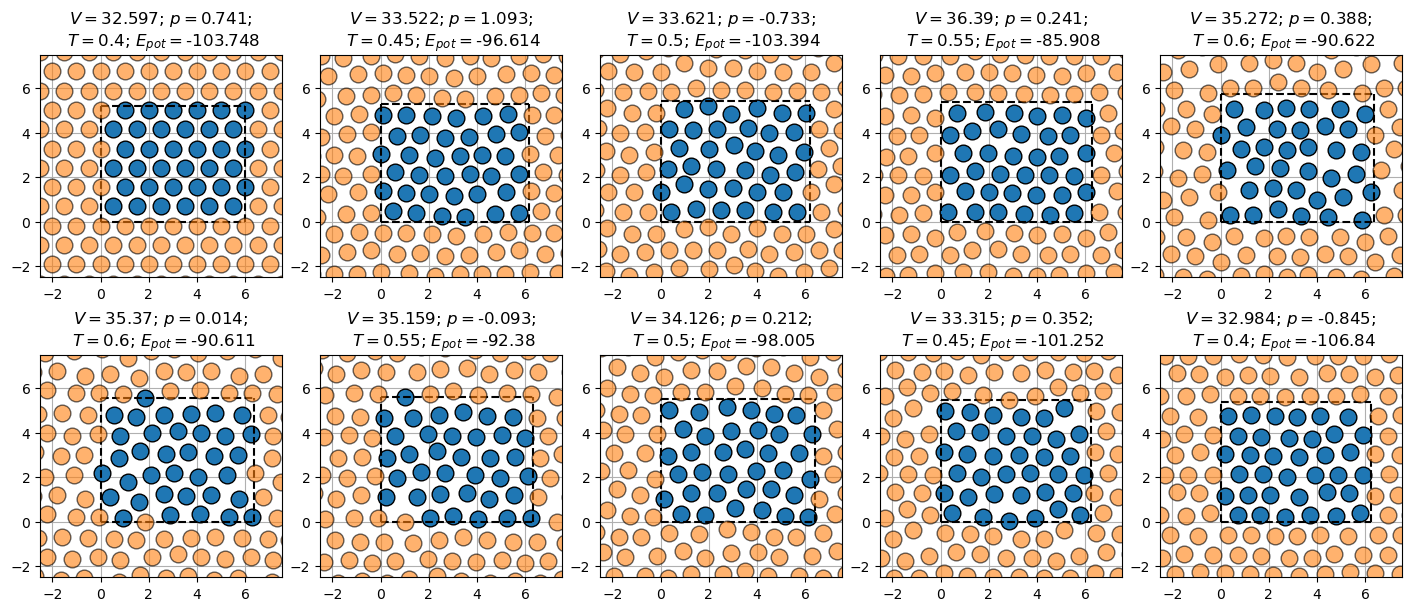

In [28]:
fig, axs = plt.subplots(2,5, figsize=(14,6), layout="constrained")

atom_plotter = Atom_plotter(markersize=12)

for temp, atom_cols, ax in zip(temps, total_logged_cols, axs.flatten()):
    ax.grid()
    ax.set_xlim([-2.5, 7.5])
    ax.set_ylim([-2.5, 7.5])
    atom_plotter(atom_col=atom_col, ax=ax, plot_cell=True)
    atom_plotter.plot_several_cells(atom_col=atom_col, ax=ax)
    atom_col.reset_plot_axes()
    atom_col = atom_cols[-1]
    v = atom_col.get_volume()
    e_pot = atom_col.get_potential_energy()
    p = atom_col.get_pressure()
    ax.set_title(rf"$V=${round(v,3)}; $p=${round(p,3)};"+"\n"+rf" $T=${temp}; "+r"$E_{pot}=$"+f"{round(e_pot,3)}")